Found 3001 images belonging to 8 classes.
Found 743 images belonging to 8 classes.
Epoch 1/25

Epoch 1: val_loss improved from inf to 2.42248, saving model to mobilenetv2_finetune_dropout.keras
47/47 - 117s - 2s/step - accuracy: 0.1310 - loss: 2.8131 - val_accuracy: 0.1655 - val_loss: 2.4225 - learning_rate: 1.0000e-05
Epoch 2/25

Epoch 2: val_loss improved from 2.42248 to 2.25731, saving model to mobilenetv2_finetune_dropout.keras
47/47 - 67s - 1s/step - accuracy: 0.1699 - loss: 2.6270 - val_accuracy: 0.1844 - val_loss: 2.2573 - learning_rate: 1.0000e-05
Epoch 3/25

Epoch 3: val_loss improved from 2.25731 to 2.12032, saving model to mobilenetv2_finetune_dropout.keras
47/47 - 52s - 1s/step - accuracy: 0.2166 - loss: 2.3842 - val_accuracy: 0.2490 - val_loss: 2.1203 - learning_rate: 1.0000e-05
Epoch 4/25

Epoch 4: val_loss improved from 2.12032 to 1.95448, saving model to mobilenetv2_finetune_dropout.keras
47/47 - 81s - 2s/step - accuracy: 0.2313 - loss: 2.2935 - val_accuracy: 0.3096 - v

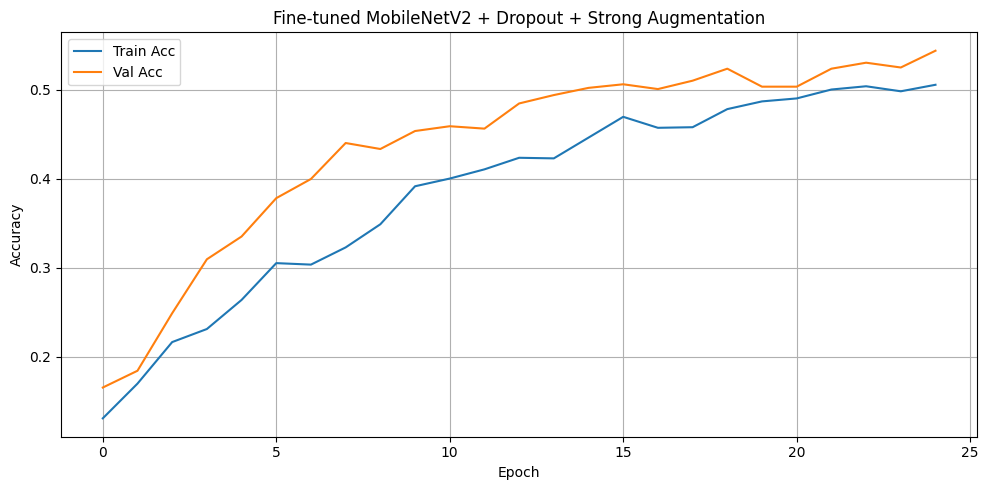

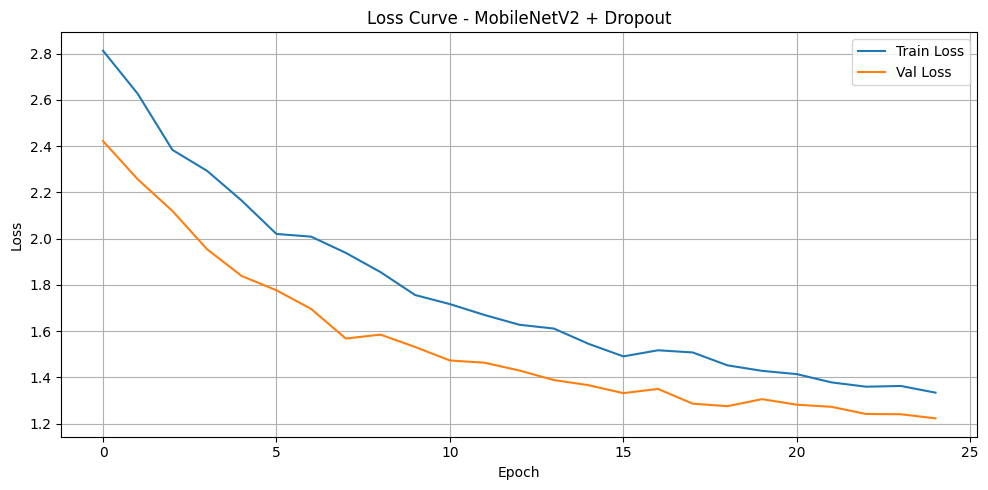

✅ Best val_acc: 0.5437 at epoch 25


In [3]:
# 📅 2025/06/06 - MobileNetV2 Fine-Tuning + Strong Augmentation + Dropout + Full Visualization

import os
import matplotlib.pyplot as plt
import numpy as np
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping

# 데이터 경로
data_dir = r"C:\Users\ghwns\HJ_git\CV-Projects\real-time-daily-activity-recognizer\images"

# 데이터 증강 (강화 버전)
datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.1,
    brightness_range=[0.8, 1.2],
    shear_range=10,
    horizontal_flip=True,
    validation_split=0.2
)

train_gen = datagen.flow_from_directory(
    data_dir,
    target_size=(128, 128),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=64,
    subset='training',
    shuffle=True
)

val_gen = datagen.flow_from_directory(
    data_dir,
    target_size=(128, 128),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=64,
    subset='validation',
    shuffle=False
)

# MobileNetV2 + Dropout
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(128, 128, 3))
base_model.trainable = True
for layer in base_model.layers[:-20]:
    layer.trainable = False

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.5)(x)  # Dropout 추가
output = Dense(train_gen.num_classes, activation='softmax')(x)
model = Model(inputs=base_model.input, outputs=output)

# Optimizer
optimizer = Adam(learning_rate=1e-5)

# 콜백
checkpoint_path = "mobilenetv2_finetune_dropout.keras"
checkpointer = ModelCheckpoint(filepath=checkpoint_path, save_best_only=True, verbose=1)
lr_reducer = ReduceLROnPlateau(monitor='val_loss', patience=3, factor=0.5, verbose=1)
early_stopper = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True, verbose=1)

# 컴파일
model.compile(optimizer=optimizer,
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# 학습
history = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=25,
    callbacks=[checkpointer, lr_reducer, early_stopper],
    verbose=2
)

# 정확도 시각화 + 저장 + 출력
acc_fig_path = r"C:\Users\ghwns\HJ_git\CV-Projects\real-time-daily-activity-recognizer\figures\exp_20250606_finetune_mobilenet_dropout.png"
plt.figure(figsize=(10, 5))
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.title('Fine-tuned MobileNetV2 + Dropout + Strong Augmentation')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig(acc_fig_path)
plt.show()

# 손실 시각화 + 저장 + 출력
loss_fig_path = r"C:\Users\ghwns\HJ_git\CV-Projects\real-time-daily-activity-recognizer\figures\exp_20250606_finetune_mobilenet_dropout_loss.png"
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Loss Curve - MobileNetV2 + Dropout')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig(loss_fig_path)
plt.show()

# 베스트 성능 출력
val_acc = history.history['val_accuracy']
best_epoch = np.argmax(val_acc) + 1
best_val = val_acc[best_epoch - 1]
print(f"✅ Best val_acc: {best_val:.4f} at epoch {best_epoch}")